# Asymmetric Tree Dataset

This dataset intends to create a biforcating tree with 8 samples, three runs per sample.


In [1]:
import utils
import gzip
import random
import string
import math
import ete3 as ete
from skbio import Alignment, DNA, DistanceMatrix
from skbio.tree import nj
import numpy as np
import skbio
import sys

In [2]:
seed = 1003
genome_size = 1 # mbp
num_samples = 8
num_runs = 3

mean_n_reads = 5e5
sd_n_reads = mean_n_reads * 0.1 # Coeff of Var = 0.1
min_n_reads = mean_n_reads / 100.0

countgraph_size = 1e8

### Don't edit below here

Constants are all in the cell above this

In [3]:
! rm -rf data 
! mkdir data
for subdir  in ['genomes', 'fastq', 'countgraphs']:
    ! mkdir data/{subdir}

Set a random seed and seed the RNG

In [4]:
random.seed(seed)
utils.random.seed(seed)

## Generate sample genomes

First, we make a tree with the following structure

In [5]:
tree = '(((A:0.1,B:0.1):0.3,C:0.2):0.1,((D:0.4, (E:0.2,F:0.15):0.3):0.1,(G:0.2,H:0.15):0.2):0.6);'

In [6]:
print(ete.Tree(tree))


         /-A
      /-|
   /-|   \-B
  |  |
  |   \-C
  |
--|      /-D
  |   /-|
  |  |  |   /-E
  |  |   \-|
   \-|      \-F
     |
     |   /-G
      \-|
         \-H


In [7]:
with open("data/asym_sample_truth.nwk", 'w') as fh:
    print(tree, file=fh)

### Make genome sequences with seq-gen

Using the GTR model of sequence evolution

In [8]:
seqgen = 'seq-gen -mGTR -s0.01 -l{len} < data/asym_sample_truth.nwk >data/asym_genomes.phy'.format(len=int(genome_size*1e6))

In [9]:
utils.run_cmd(seqgen)

0

Make a random genome, and samples derived from it. Write it to a fasta file.

In [10]:
seqs = []
with open("data/asym_genomes.phy") as fh:
    next(fh)  # nuke first line
    for line in fh:
        name, seq = line.strip().split()
        seqs.append(skbio.Sequence(seq, {'id': name}))

In [11]:
aln = skbio.Alignment(seqs)

## Make NJ tree


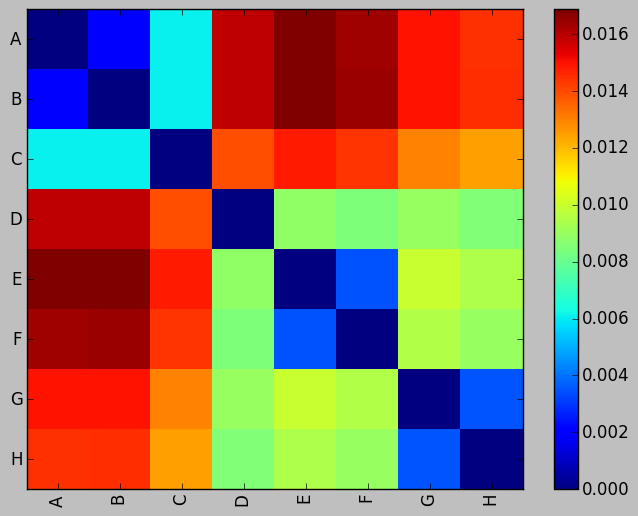

In [12]:
distmat = aln.distances()
distmat

Make a repeated version of this distance matrix, which can be directly (visually) compared with the result of kWIP, which will of course be of the runs, not the genomes themselves.

In [13]:
distmat_reps = DistanceMatrix(
    np.repeat(np.repeat(distmat.data,num_runs, axis=1), num_runs, axis=0))
run_names = ['{}-{}'.format(g, i) for g in distmat.ids for i in range(num_runs)]

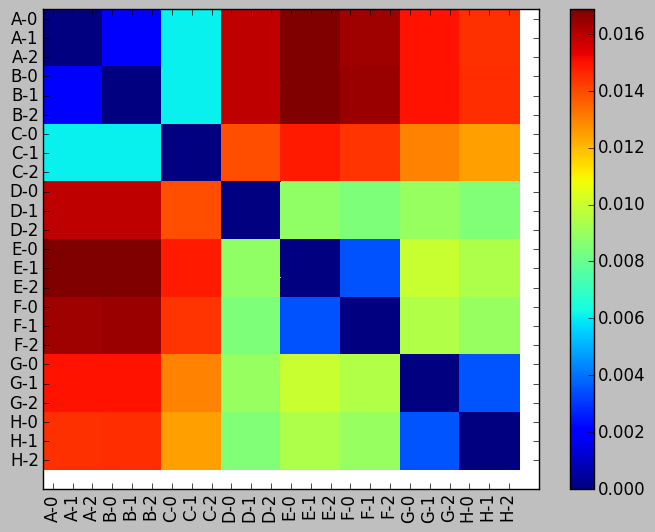

In [14]:
distmat_reps.ids = run_names
distmat_reps

In [15]:
tree_reps = nj(distmat_reps)
tree_reps.write('data/asym_runs.nwk')

'data/asym_runs.nwk'

### Generate reads

In [16]:
runs = {}
run_read_counts = {}

for seq in seqs:
    genome = seq.metadata['id']
    print('Genome', genome, end=', reps: ')
    runs[genome] = []
    
    # write genome
    fas = 'data/genomes/asym_{}.fasta'.format(genome)
    seq.write(fas, format='fasta')
    
    # create each run's reads
    for j in range(num_runs):
        print(j, end=' ')
        sys.stdout.flush()
        run = '{}-{}'.format(genome, j)
        fq = "data/fastq/asym_{}_il.fq".format(run)
        n_reads = max(int(random.gauss(mean_n_reads, sd_n_reads)), min_n_reads)
        utils.wgsim(n_reads, fas, fq)
        runs[genome].append(fq)
        run_read_counts[run] = n_reads
    print()

Genome A, reps: 0 1 2 
Genome B, reps: 0 1 2 
Genome C, reps: 0 1 2 
Genome D, reps: 0 1 2 
Genome E, reps: 0 1 2 
Genome F, reps: 0 1 2 
Genome G, reps: 0 1 2 
Genome H, reps: 0 1 2 


### Hash samples

In [17]:
def countgraph(fq, cg, x=1e9, k=20, n=1, quiet=True):
    lic = "load-into-countgraph.py -T 12 -N {N} -k {k} -x {x} -s tsv -b {cg} {fq}".format(
            N=n, k=k, x=x, cg=cg, fq=fq)
    print(lic)
    sys.stdout.flush()
    utils.run_cmd(lic, quiet)

In [18]:
countgraphs = []
for genome in runs:
    for i, fq in enumerate(runs[genome]):
        cg = 'data/countgraphs/bifork_{}-{}.cg.gz'.format(genome, i)
        countgraphs.append(cg)
        countgraph(fq, cg, x=countgraph_size, k=20)

load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_C-0.cg.gz data/fastq/asym_C-0_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_C-1.cg.gz data/fastq/asym_C-1_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_C-2.cg.gz data/fastq/asym_C-2_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_F-0.cg.gz data/fastq/asym_F-0_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_F-1.cg.gz data/fastq/asym_F-1_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_F-2.cg.gz data/fastq/asym_F-2_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_G-0.cg.gz data/fastq/asym_G-0_il.fq
load-into-countgraph.py -T 12 -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_G-1.cg.gz data/fastq/asym_G-

## Run `kWIP`

In [19]:
def kwip(countgraphs, dist, kern='', weighted=True, quiet=True):
    if kern:
        kern = '-k {kern}'.format(kern=kern)
    unweight = ''  
    if not weighted:
        unweight = '-U'        
    cgs = ' '.join(countgraphs)
    cmd = "kwip {kern} {wht} -d {dist} {cgs}".format(wht=unweight, kern=kern, dist=dist, cgs=cgs)
    print(cmd)
    utils.run_cmd(cmd, quiet)
   

In [20]:
kwip(sorted(countgraphs), 'data/asym-kwip.dist', 'data/asym-kwip.kern')

kwip -k data/asym-kwip.kern  -d data/asym-kwip.dist data/countgraphs/bifork_A-0.cg.gz data/countgraphs/bifork_A-1.cg.gz data/countgraphs/bifork_A-2.cg.gz data/countgraphs/bifork_B-0.cg.gz data/countgraphs/bifork_B-1.cg.gz data/countgraphs/bifork_B-2.cg.gz data/countgraphs/bifork_C-0.cg.gz data/countgraphs/bifork_C-1.cg.gz data/countgraphs/bifork_C-2.cg.gz data/countgraphs/bifork_D-0.cg.gz data/countgraphs/bifork_D-1.cg.gz data/countgraphs/bifork_D-2.cg.gz data/countgraphs/bifork_E-0.cg.gz data/countgraphs/bifork_E-1.cg.gz data/countgraphs/bifork_E-2.cg.gz data/countgraphs/bifork_F-0.cg.gz data/countgraphs/bifork_F-1.cg.gz data/countgraphs/bifork_F-2.cg.gz data/countgraphs/bifork_G-0.cg.gz data/countgraphs/bifork_G-1.cg.gz data/countgraphs/bifork_G-2.cg.gz data/countgraphs/bifork_H-0.cg.gz data/countgraphs/bifork_H-1.cg.gz data/countgraphs/bifork_H-2.cg.gz


In [21]:
kwip(sorted(countgraphs), 'data/asym-ip.dist', 'data/asym-ip.kern', weighted=False)

kwip -k data/asym-ip.kern -U -d data/asym-ip.dist data/countgraphs/bifork_A-0.cg.gz data/countgraphs/bifork_A-1.cg.gz data/countgraphs/bifork_A-2.cg.gz data/countgraphs/bifork_B-0.cg.gz data/countgraphs/bifork_B-1.cg.gz data/countgraphs/bifork_B-2.cg.gz data/countgraphs/bifork_C-0.cg.gz data/countgraphs/bifork_C-1.cg.gz data/countgraphs/bifork_C-2.cg.gz data/countgraphs/bifork_D-0.cg.gz data/countgraphs/bifork_D-1.cg.gz data/countgraphs/bifork_D-2.cg.gz data/countgraphs/bifork_E-0.cg.gz data/countgraphs/bifork_E-1.cg.gz data/countgraphs/bifork_E-2.cg.gz data/countgraphs/bifork_F-0.cg.gz data/countgraphs/bifork_F-1.cg.gz data/countgraphs/bifork_F-2.cg.gz data/countgraphs/bifork_G-0.cg.gz data/countgraphs/bifork_G-1.cg.gz data/countgraphs/bifork_G-2.cg.gz data/countgraphs/bifork_H-0.cg.gz data/countgraphs/bifork_H-1.cg.gz data/countgraphs/bifork_H-2.cg.gz


## Analyse the output 


In [22]:
from skbio import DistanceMatrix
from skbio.tree import nj

Make a tree from `kWIP`'s output

In [23]:
kwip_dist = DistanceMatrix.read("data/asym-kwip.dist")
ip_dist = DistanceMatrix.read("data/asym-ip.dist")
kwip_dist.ids = run_names
ip_dist.ids = run_names

In [24]:
kwip_dist.plot(title="kWIP Distances")
distmat_reps.ids = run_names
distmat_reps.plot(title='True Distances')
ip_dist.plot(title='Unweighted kWIP Distance')
print() # 

In [25]:
kwip_tree = nj(kwip_dist)
kwip_tree.write('data/asym_kwip.nwk')

'data/asym_kwip.nwk'

In [26]:
ip_tree = nj(ip_dist)
ip_tree.write('data/asym_ip.nwk')

'data/asym_ip.nwk'

## Robinson-Foulds distance

A measure of tree concordance. Smaller is better

In [29]:
true_tree = ete.Tree("data/asym_runs.nwk")
print(true_tree)
kwip_tree = ete.Tree("data/asym_kwip.nwk")
print(kwip_tree)
ip_tree = ete.Tree("data/asym_ip.nwk")
print(ip_tree)


   /-H-1
  |
  |   /-H-0
  |  |
  |  |               /-B-2
  |  |            /-|
  |  |           |  |   /-B-1
  |  |           |   \-|
  |  |         /-|      \-B-0
  |  |        |  |
  |  |        |  |   /-A-2
  |  |        |   \-|
  |  |      /-|     |   /-A-1
  |  |     |  |      \-|
  |  |     |  |         \-A-0
  |  |     |  |
  |--|     |  |   /-C-2
  |  |     |   \-|
  |  |     |     |   /-C-1
  |  |   /-|      \-|
  |  |  |  |         \-C-0
  |  |  |  |
  |  |  |  |      /-D-2
--|  |  |  |   /-|
  |  |  |  |  |  |   /-D-1
  |  |  |  |  |   \-|
  |  |  |  |  |      \-D-0
  |  |  |   \-|
  |  |  |     |      /-E-2
  |  |  |     |   /-|
  |   \-|     |  |  |   /-E-1
  |     |     |  |   \-|
  |     |      \-|      \-E-0
  |     |        |
  |     |        |   /-F-2
  |     |         \-|
  |     |           |   /-F-1
  |     |            \-|
  |     |               \-F-0
  |     |
  |     |   /-G-2
  |      \-|
  |        |   /-G-1
  |         \-|
  |            \-G-0
  |
   \-H-

And the RF distance is....

In [28]:
print('kWIP:', kwip_tree.robinson_foulds(true_tree, unrooted_trees=True)[0])
print('Unweighted:', ip_tree.robinson_foulds(true_tree, unrooted_trees=True)[0])

kWIP: 14
Unweighted: 14


## Hierarchical clustering

And ploting by matplotlib

In [30]:
from scipy.cluster import hierarchy as hier
import matplotlib.pyplot as plt

In [31]:
%matplotlib inline


In [32]:
z = hier.linkage(kwip_dist.condensed_form(), method='complete')

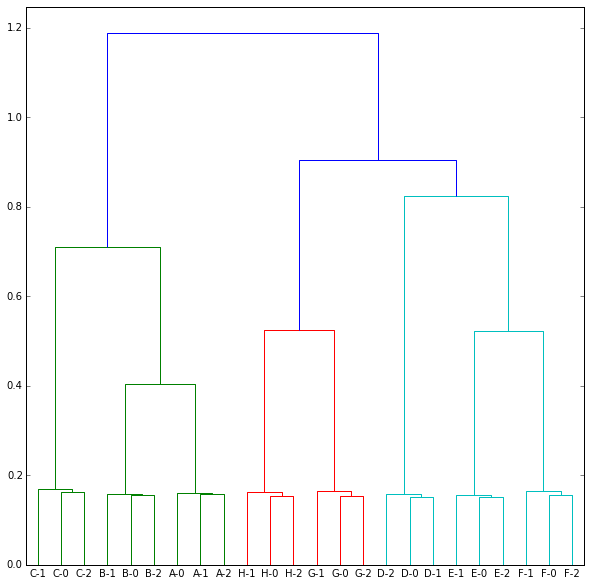

In [35]:
plt.figure(figsize=(10, 10))
x = hier.dendrogram(z, labels=run_names)